# Explore here

In [1]:
'''!pip install ultralytics'''

'!pip install ultralytics'

In [2]:
'''!pip install opencv-python'''

'!pip install opencv-python'

In [3]:
'''pip install opendatasets'''

'pip install opendatasets'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pickle import dump
import os
import opendatasets as od
import zipfile
import tensorflow as tf
from keras.preprocessing import image
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, SGD
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.losses import *
from tensorflow.keras import *
import random
import hashlib
import cv2
from matplotlib import pyplot as plt
import re
import ultralytics
from IPython.display import clear_output

First of all, we download the files.

In [5]:
'''# Assign the Kaggle data set URL into variable
dataset = "https://www.kaggle.com/datasets/youthamj/captchaobjectdetection"
# Using opendatasets let's download the data sets
od.download(dataset, data_dir="../data/raw/", force=True)'''

'# Assign the Kaggle data set URL into variable\ndataset = "https://www.kaggle.com/datasets/youthamj/captchaobjectdetection"\n# Using opendatasets let\'s download the data sets\nod.download(dataset, data_dir="../data/raw/", force=True)'

Now we calculate the number of files donwloaded.

In [6]:
'''data_dir = "../data/raw/captchaobjectdetection"

print(len([file for file in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))]))'''

'data_dir = "../data/raw/captchaobjectdetection"\n\nprint(len([file for file in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))]))'

Then, we calculate the number of images (.png extension).

In [7]:
'''im_count = 0

for im in Path(data_dir).glob("*.png"):
    im_count+=1

print(im_count)'''

'im_count = 0\n\nfor im in Path(data_dir).glob("*.png"):\n    im_count+=1\n\nprint(im_count)'

We can observe that the number of images and files differ by one since there are 200,001 files in total and 100,000 images. Therefore, we have one extra file aside from those associated with each image.

The extra file is all_sequences.txt, that contains the relationship between the name of the image/file and the characters that contains.

We will use this file to asociate the characters in each row to the number asociated to it in the YOLO files.

The content of the files could be duplicated since there could be two different images with the same characters to decipher, so we only check there are no duplicates in our images.

In [8]:
'''def hashfile(file_path):
    hasher = hashlib.sha256()
    with open(file_path, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


hashes = pd.DataFrame(columns=["filename","hash"])
hashes_dup = pd.DataFrame(columns=["filename","hash"])

for filename in Path(data_dir).glob("*.png"):
  if filename.is_file():
    file_hash = hashfile(filename)
    if (hashes["hash"] != file_hash).all():
      hashes.loc[len(hashes)] = [filename, file_hash]
    else:
      hashes_dup.loc[len(hashes_dup)] = [filename, file_hash]

if hashes_dup.empty:
  print("No duplicates in the dataset.")
else:
    print(hashes_dup)'''



'def hashfile(file_path):\n    hasher = hashlib.sha256()\n    with open(file_path, \'rb\') as f:\n        buf = f.read()\n        hasher.update(buf)\n    return hasher.hexdigest()\n\n\nhashes = pd.DataFrame(columns=["filename","hash"])\nhashes_dup = pd.DataFrame(columns=["filename","hash"])\n\nfor filename in Path(data_dir).glob("*.png"):\n  if filename.is_file():\n    file_hash = hashfile(filename)\n    if (hashes["hash"] != file_hash).all():\n      hashes.loc[len(hashes)] = [filename, file_hash]\n    else:\n      hashes_dup.loc[len(hashes_dup)] = [filename, file_hash]\n\nif hashes_dup.empty:\n  print("No duplicates in the dataset.")\nelse:\n    print(hashes_dup)'

Let's check then an inmage, and it's bounding boxes, to see everything goes as expected in the YOLO files.

Now, we check as an example a random image and its bounding box, to check the values are defined as expected.

In [9]:
def plot_img(img_dir, txt_dir):
    image = cv2.imread(img_dir)
    image_hight = image.shape[0]
    image_width = image.shape[1]

    filename = txt_dir

    with open(filename, 'r', encoding='utf-8') as f:
        text_list = [list(map(float, line.strip().split())) for line in f]


    for i in range(len(text_list)):
        x0 = text_list[i][1] - text_list[1][3] / 2
        x1 = text_list[i][1] + text_list[i][3] / 2
        y0 = text_list[i][2] - text_list[i][4] / 2
        y1 = text_list[i][2] + text_list[i][4] / 2

        start_point = (int(x0*image_width), int(y0*image_hight))
        end_point = (int(x1*image_width), int(y1*image_hight))

        img = cv2.rectangle(image, start_point, end_point, color=(255, 0, 0), thickness=2)

    plt.imshow(img)

In [10]:
'''img_dir = "../data/raw/images/train/10084.png"

txt_dir = "../data/raw/labels/train/10084.txt"

plot_img(img_dir, txt_dir)
'''

'img_dir = "../data/raw/images/train/10084.png"\n\ntxt_dir = "../data/raw/labels/train/10084.txt"\n\nplot_img(img_dir, txt_dir)\n'

Finally, it's time to create the folders to divide the files in txt and images, and then split then in 3 subsets of train, validation and test, in a rate of 60-20-20.

In [11]:
'''os.makedirs("../data/raw/images")
os.makedirs("../data/raw/labels")'''

'os.makedirs("../data/raw/images")\nos.makedirs("../data/raw/labels")'

In [12]:
'''for im in Path("data_dir").glob("*.png"):
    shutil.move(im, os.path.join("../data/raw/images", im.name))

for im in Path("data_dir").glob("*.txt"):
    shutil.move(im, os.path.join("../data/raw/labels", im.name))

for im in Path("../data/raw/labels").glob("all_sequences.txt"):
    shutil.move(im, os.path.join("data_dir", im.name))'''

'for im in Path("data_dir").glob("*.png"):\n    shutil.move(im, os.path.join("../data/raw/images", im.name))\n\nfor im in Path("data_dir").glob("*.txt"):\n    shutil.move(im, os.path.join("../data/raw/labels", im.name))\n\nfor im in Path("../data/raw/labels").glob("all_sequences.txt"):\n    shutil.move(im, os.path.join("data_dir", im.name))'

In [13]:
'''os.makedirs("../data/raw/images/train")
os.makedirs("../data/raw/images/val")
os.makedirs("../data/raw/images/test")'''

'os.makedirs("../data/raw/images/train")\nos.makedirs("../data/raw/images/val")\nos.makedirs("../data/raw/images/test")'

In [14]:
'''os.makedirs("../data/raw/labels/train")
os.makedirs("../data/raw/labels/val")
os.makedirs("../data/raw/labels/test")'''

'os.makedirs("../data/raw/labels/train")\nos.makedirs("../data/raw/labels/val")\nos.makedirs("../data/raw/labels/test")'

In [15]:
'''origin = "../data/raw/images"
destiny_train = "../data/raw/images/train"
destiny_val = "../data/raw/images/val"
destiny_test = "../data/raw/images/test"

files = [f for f in os.listdir(origin) if os.path.isfile(os.path.join(origin, f))]
    
size_to_move = int(len(files) * (20 / 100))
    
files_to_move_val = random.sample(files, size_to_move)

for file in files_to_move_val:
    shutil.move(os.path.join(origin, file), os.path.join(destiny_val, file))

files = [f for f in os.listdir(origin) if os.path.isfile(os.path.join(origin, f))]
files_to_move_test = random.sample(files, size_to_move)

for file in files_to_move_test:
    shutil.move(os.path.join(origin, file), os.path.join(destiny_test, file))

for im in Path("../data/raw/images").glob("*.png"):
    shutil.move(im, os.path.join("../data/raw/images/train", im.name))'''

'origin = "../data/raw/images"\ndestiny_train = "../data/raw/images/train"\ndestiny_val = "../data/raw/images/val"\ndestiny_test = "../data/raw/images/test"\n\nfiles = [f for f in os.listdir(origin) if os.path.isfile(os.path.join(origin, f))]\n    \nsize_to_move = int(len(files) * (20 / 100))\n    \nfiles_to_move_val = random.sample(files, size_to_move)\n\nfor file in files_to_move_val:\n    shutil.move(os.path.join(origin, file), os.path.join(destiny_val, file))\n\nfiles = [f for f in os.listdir(origin) if os.path.isfile(os.path.join(origin, f))]\nfiles_to_move_test = random.sample(files, size_to_move)\n\nfor file in files_to_move_test:\n    shutil.move(os.path.join(origin, file), os.path.join(destiny_test, file))\n\nfor im in Path("../data/raw/images").glob("*.png"):\n    shutil.move(im, os.path.join("../data/raw/images/train", im.name))'

In [16]:
'''destiny_train_im = "../data/raw/images/train"
destiny_val_im = "../data/raw/images/val"
destiny_test_im = "../data/raw/images/test"

origin_txt = "../data/raw/labels"
destiny_train_txt = "../data/raw/labels/train"
destiny_val_txt = "../data/raw/labels/val"
destiny_test_txt = "../data/raw/labels/test"

im_train = {os.path.splitext(f)[0] for f in os.listdir(destiny_train_im) if os.path.isfile(os.path.join(destiny_train_im, f))}
im_val = {os.path.splitext(f)[0] for f in os.listdir(destiny_val_im) if os.path.isfile(os.path.join(destiny_val_im, f))}
im_test = {os.path.splitext(f)[0] for f in os.listdir(destiny_test_im) if os.path.isfile(os.path.join(destiny_test_im, f))}

for file in os.listdir(origin_txt):
    path = os.path.join(origin_txt, file)

    if os.path.isfile(path):
        root, _ = os.path.splitext(file)

        # Si el nombre coincide con los nombres de la carpeta de imágenes, moverlo
        if root in im_train:
            shutil.move(path, os.path.join(destiny_train_txt, file))
        
        elif root in im_val:
            shutil.move(path, os.path.join(destiny_val_txt, file))

        elif root in im_test:
            shutil.move(path, os.path.join(destiny_test_txt, file))'''

'destiny_train_im = "../data/raw/images/train"\ndestiny_val_im = "../data/raw/images/val"\ndestiny_test_im = "../data/raw/images/test"\n\norigin_txt = "../data/raw/labels"\ndestiny_train_txt = "../data/raw/labels/train"\ndestiny_val_txt = "../data/raw/labels/val"\ndestiny_test_txt = "../data/raw/labels/test"\n\nim_train = {os.path.splitext(f)[0] for f in os.listdir(destiny_train_im) if os.path.isfile(os.path.join(destiny_train_im, f))}\nim_val = {os.path.splitext(f)[0] for f in os.listdir(destiny_val_im) if os.path.isfile(os.path.join(destiny_val_im, f))}\nim_test = {os.path.splitext(f)[0] for f in os.listdir(destiny_test_im) if os.path.isfile(os.path.join(destiny_test_im, f))}\n\nfor file in os.listdir(origin_txt):\n    path = os.path.join(origin_txt, file)\n\n    if os.path.isfile(path):\n        root, _ = os.path.splitext(file)\n\n        # Si el nombre coincide con los nombres de la carpeta de imágenes, moverlo\n        if root in im_train:\n            shutil.move(path, os.path.jo

Let's check the folders have the number of files expected.

In [17]:
'''print(len(os.listdir(destiny_train_im)))
print(len(os.listdir(destiny_val_im)))
print(len(os.listdir(destiny_test_im)))

print(len(os.listdir(destiny_train_txt)))
print(len(os.listdir(destiny_val_txt)))
print(len(os.listdir(destiny_test_txt)))'''

'print(len(os.listdir(destiny_train_im)))\nprint(len(os.listdir(destiny_val_im)))\nprint(len(os.listdir(destiny_test_im)))\n\nprint(len(os.listdir(destiny_train_txt)))\nprint(len(os.listdir(destiny_val_txt)))\nprint(len(os.listdir(destiny_test_txt)))'

Meanwhile, we've been analyzing the file all_sequences.txt, with the characters associated to each image, and compare them with every txt file associated to each image, to obtain the YOLO yaml index associated to each character.

We noticed that there are some characters missing, so we check this characters don't exist in any file.

In [18]:
'''filename = "../data/raw/captchaobjectdetection/all_sequences.txt"

with open(filename, 'r', encoding='utf-8') as f:
  char_list = [linea.strip().split(",") for linea in f]

data = []
for item in char_list:
   if re.search(r"iIlLoO01", item[1]):
    data.append(item)

print(data)'''

'filename = "../data/raw/captchaobjectdetection/all_sequences.txt"\n\nwith open(filename, \'r\', encoding=\'utf-8\') as f:\n  char_list = [linea.strip().split(",") for linea in f]\n\ndata = []\nfor item in char_list:\n   if re.search(r"iIlLoO01", item[1]):\n    data.append(item)\n\nprint(data)'

Let's begin with the YOLO model.

In [30]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

In [31]:
img_dir = "../data/raw/images/train/3.png"
image = cv2.imread(img_dir)
image_size = image.size

First of all, we train the model with our dataset.

In [21]:
'''results = model.train(
    data="./dataset.yaml",  # Ruta al archivo de configuración del dataset
    epochs=50,  # Número de épocas de entrenamiento
    imgsz=image_size,  # Tamaño de las imágenes
    batch=16  # Tamaño del batch
)'''

'results = model.train(\n    data="./dataset.yaml",  # Ruta al archivo de configuración del dataset\n    epochs=50,  # Número de épocas de entrenamiento\n    imgsz=image_size,  # Tamaño de las imágenes\n    batch=16  # Tamaño del batch\n)'

When we try to train the model, we can see the following error:

val: WARNING  C:\4Geeks\Projects\captcha-processor\data\raw\images\val\9998.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0333]
train: WARNING  C:\4Geeks\Projects\captcha-processor\data\raw\images\train\99960.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0333]

It seems that thousands of the YOLO files have at least, one value bigger than 1, wich is not valid, due to value normalization.

Let's copy some of this images and txt in the original folder, soy we can see whats happenning, and what can we do.

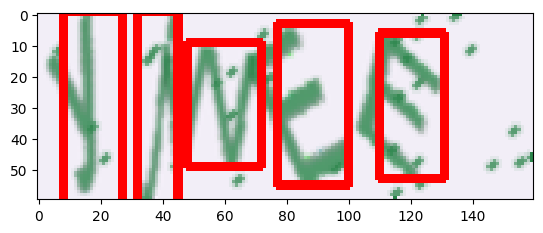

In [ ]:
'''img_dir = "../data/interim/10193.png"
txt_dir = "../data/interim/10193.txt"

plot_img(img_dir, txt_dir)'''

Let's compare the results whith the YOLO file normalized (replacing any value bigger than one, with one).

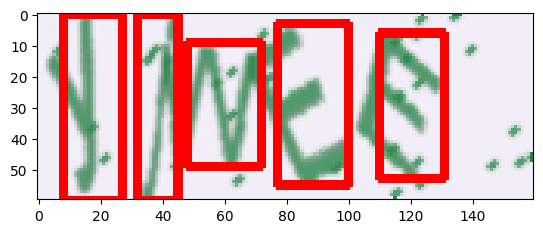

In [ ]:
'''img_dir = "../data/interim/10193.png"
txt_dir = "../data/interim/10193_normalized.txt"

plot_img(img_dir, txt_dir)'''

We can notice that the rectangles stay the same, but the values are now valid in YOLO files, so they have no values outside 0 to 1.

So, the key now is to replace every value bigger with one, to one, in every text file all along the YOLO files.

First of all in this step is to create a back up of the original txt.

In [24]:
'''shutil.copytree("../data/raw/labels/", "../data/raw/captchaobjectdetection", dirs_exist_ok=True)'''

'shutil.copytree("../data/raw/labels/", "../data/raw/captchaobjectdetection", dirs_exist_ok=True)'

And then, modify the files to normalize values.

In [25]:
'''dir = "../data/raw/labels"

for file in Path(dir).rglob("*.txt"):   
    with open(file, "r+", encoding="utf-8") as f:
        lines = f.readlines()
        f.seek(0)  
        for line in lines:
            values = list(map(float, line.strip().split()))
            values = [1 if x > 1 else x for x in values]
            f.write(" ".join(map(str, values)) + "\n")
        f.truncate() '''

'dir = "../data/raw/labels"\n\nfor file in Path(dir).rglob("*.txt"):   \n    with open(file, "r+", encoding="utf-8") as f:\n        lines = f.readlines()\n        f.seek(0)  \n        for line in lines:\n            values = list(map(float, line.strip().split()))\n            values = [1 if x > 1 else x for x in values]\n            f.write(" ".join(map(str, values)) + "\n")\n        f.truncate() '

Let's try again the YOLO training, in order to see if our changes normalizing the txt file values have solved the problem.

In [ ]:
'''results = model.train(
    data="./dataset.yaml",  # Ruta al archivo de configuración del dataset
    epochs=50,  # Número de épocas de entrenamiento
    imgsz=image_size,  # Tamaño de las imágenes
    batch=16  # Tamaño del batch
)
'''

New https://pypi.org/project/ultralytics/8.3.81 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.80  Python-3.9.13 torch-2.6.0+cpu CPU (Intel Core(TM) i7-4750HQ 2.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=28800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning C:\4Geeks\Projects\captcha-processor\data\raw\labels\train.cache... 60000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60000/60000 [00:00<?, ?it/s]
val: Scanning C:\4Geeks\Projects\captcha-processor\data\raw\labels\val.cache... 20000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


Then, we validate it.

In [27]:
'''results = model.val()'''

'results = model.val()'

And finally, save the model.

In [28]:
'''model.export(format="../models/captcha_yolo8_b16_e50") '''

'model.export(format="../models/captcha_yolo8_b16_e50") '

In [29]:
'''model = YOLO("runs/train/exp/weights/best.pt")  # Cargar el mejor modelo entrenado

# Realizar predicción en una imagen
results = model("imagen_de_prueba.jpg")

# Mostrar resultados
results.show()'''

'model = YOLO("runs/train/exp/weights/best.pt")  # Cargar el mejor modelo entrenado\n\n# Realizar predicción en una imagen\nresults = model("imagen_de_prueba.jpg")\n\n# Mostrar resultados\nresults.show()'